In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l
from dmba import classificationSummary
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
df = pd.read_csv("files/data.csv")
not_important = ['id','uri','track_href','analysis_url','duration_ms','type']
dfc = df.drop(columns=not_important)

In [3]:
# Classification 
# Predict wheter (for example) a record is yes or no
# Cutoff -> If above, then 1 else 0 ()

In [4]:
# Naive Bayes
# P(y), given predictors
# 1. For a binary response, estimate the individual conditional probability for each predictor P(Xj|Y=i)
# 2. Multiply all probabilities, and multiply it by the proportion of Xj values among the Y=i in the training set. Do this for every i
# 3. Estimate probability of outcome i by calculating it and dividing for the sum of the probability of all the others classes(normalizing)
# 4. Assign to the class with highest probability
# Naive because assuming all predictors are independent

In [5]:
predictors = ['energy','danceability']
target = 'genre'

data = dfc[dfc['genre'].isin(['chill','hard-rock'])]
X = data[predictors]
y = data[target]

In [6]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01)

In [7]:
naive_model.predict(X)

array(['hard-rock', 'hard-rock', 'chill', ..., 'hard-rock', 'hard-rock',
       'hard-rock'], dtype='<U9')

In [8]:
naive_model.predict_proba(X)

array([[0.49823111, 0.50176889],
       [0.49823111, 0.50176889],
       [0.51061949, 0.48938051],
       ...,
       [0.45261439, 0.54738561],
       [0.49521296, 0.50478704],
       [0.48673918, 0.51326082]])

In [9]:
## Discriminant analysis
# Linear Discrimant Analysis -> Assumes predictors are normaly distributed variables Covariance matrix assume the be the same across classes
# Covariance Matrix -> Consists of the individual variances and the covariances between variables (correlation is covariance normalized)
# Quadratic Discrimant Analysis -> One covariance matrix for each group -> Leads to quadratic function

In [10]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
print(pd.DataFrame(lda.scalings_, index=X.columns))

                     0
energy        3.440516
danceability -4.453353


In [11]:
pred = pd.DataFrame(lda.predict_proba(X),
                    columns=lda.classes_)
print(pred.head())

      chill  hard-rock
0  0.460052   0.539948
1  0.460052   0.539948
2  0.668079   0.331921
3  0.863497   0.136503
4  0.752838   0.247162


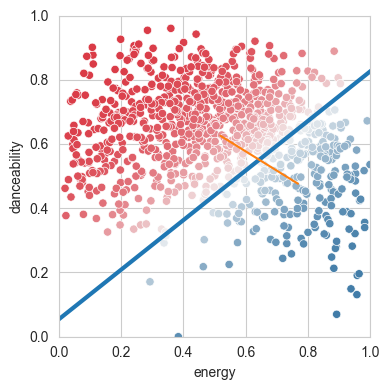

In [12]:
center = np.mean(lda.means_, axis=0)
slope = - lda.scalings_[0] / lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([X, pred['chill']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='energy', y='danceability',
                    hue='chill', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*lda.means_.transpose())

plt.tight_layout()
plt.show()

In [26]:
# Logistic Regression -> GLM with a logit as link function
logit_reg = LogisticRegression(penalty='l2', solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  0.10739897240649807
classes ['chill' 'hard-rock']


,coeff
energy,4.519160
danceability,-5.554022


In [27]:
#GLM -> A probability distribution and a link function

In [28]:
#GLM -> A probability distribution and a link function
# Predicted value are in term of the log-odds
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
 columns=y.unique())
pred.describe()

,chill,hard-rock
count,2000.000000,2000.000000
mean,-0.940817,-0.985221
std,0.797301,0.909061
min,-3.884634,-4.420803
25%,-1.469014,-1.506021
50%,-0.733860,-0.654028
75%,-0.250760,-0.261564
max,-0.012097,-0.020770


In [29]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
 columns=y.unique())
pred.describe()

,chill,hard-rock
count,2000.000000,2000.000000
mean,0.500054,0.499946
std,0.291291,0.291291
min,0.020555,0.012025
25%,0.230153,0.221791
50%,0.480053,0.519947
75%,0.778209,0.769847
max,0.987975,0.979445


In [30]:
# Interpreting coefficients
# Odds ratio -> Odds(Y=1|X=1)/Odds(Y=1|X=0)
# An increase in 1 results in an increase of exp(f) in the odds ratio

In [33]:
# Logistic Regression vs Log Reg
# Splines can be fitted to LR
# Both assume a parametric linear form relating predictors with response
# LogReg fitting -> MLE for binary -> Binary cross entropy 

3.871855133581847e-05

In [34]:
# Assessing model
y_numbers = [1 if yi == 'hard-rock' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -946.20
Date:                Mon, 04 Dec 2023   Deviance:                       1892.4
Time:                        08:44:50   Pearson chi2:                 2.17e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3560
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
energy           4.8472      0.289     16.757   

In [37]:
## Using splines
import statsmodels.formula.api as smf
formula = ('genre ~ bs(danceability, df=3) + bs(energy, df=3)')
model = smf.glm(formula=formula, data=data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                          Generalized Linear Model Regression Results                           
Dep. Variable:     ['genre[chill]', 'genre[hard-rock]']   No. Observations:                 2000
Model:                                              GLM   Df Residuals:                     1993
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    Logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -909.24
Date:                                  Mon, 04 Dec 2023   Deviance:                       1818.5
Time:                                          08:47:16   Pearson chi2:                 1.78e+03
No. Iterations:                                       7   Pseudo R-squ. (CS):             0.3794
Covariance Type:                              nonrobust                                         
                              

In [ ]:
# Evaluating classification models
# Train,val and test
# Acc ->  Cases correcty classfied
# Confusion matrix -> 2x2 of the record counts by their predicted and actual classification status.
# Recall/Sensitivy -> All the 1s that are classified as 1 (How much of the 1s where retrieved? (Information retrieval))
# Precision -> Percent of classified as 1s that are 1s
# Specificity -> Proportion of 0s classified as 0s 
# Roc Curve -> Sensitivy vs Specificity
# Lift -> How effective the model is at identifying 1s at different probability cutoffs

In [40]:
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'chill'
true_y = y == 'chill'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = chill', 'Y = hardrock'],
                       columns=['Yhat = chill', 'Yhat = hardrock'])
print(conf_mat)

              Yhat = chill  Yhat = hardrock
Y = chill              763              237
Y = hardrock           207              793


In [52]:
Xc = X.copy()
Xc['true_y'] = y
Xc['pred_y'] = logit_reg.predict(X)
cm = pd.crosstab(Xc['true_y'],Xc['pred_y'])
cm

pred_y,chill,hard-rock
true_y,,
chill,763,237
hard-rock,207,793


In [50]:
acc = (Xc['true_y'] == Xc['pred_y']).mean()
print(acc)

0.778


In [62]:
recall = cm.loc['chill']['chill'] / cm.loc['chill'].sum()
specifity = cm.loc['hard-rock']['hard-rock'] / cm.loc['hard-rock'].sum()
precision = cm.loc['chill']['chill'] / cm['chill'].sum()
precision,recall, specifity

(0.7865979381443299, 0.763, 0.793)

In [63]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['chill', 'hard-rock'])

(array([0.78659794, 0.76990291]),
 array([0.763, 0.793]),
 array([0.77461929, 0.78128079]),
 array([1000, 1000], dtype=int64))

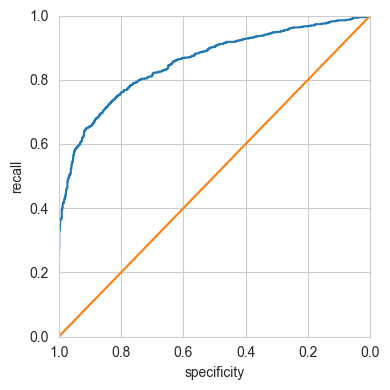

In [66]:
# Precision recall curve can be useful also in highly imbalanced datasets

fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='chill')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

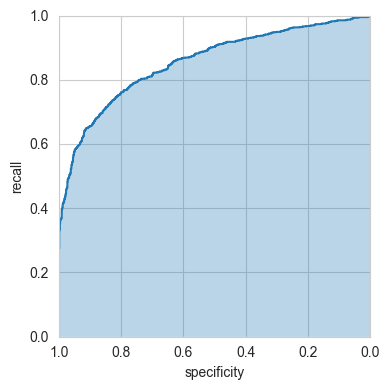

In [67]:
# AUC -> Area under curve
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='chill')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

In [71]:
# Strategies for unbalanced data
# 1. Under/Over sampling -> SMOTE -> Not good in real world projects -> Can hurt calibration
# 2. Cost sensitive learning -> Assign weights (expected returns) to confusion matrix and use it to select cut-offs

In [72]:
sp_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
sp_tree.fit(X, y)

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'hard-rock' else 0 for yi in y]))

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


True